In [32]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
import matplotlib.pyplot as plt
%matplotlib inline

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0]) 
        dataY.append(signal_data[i + look_back, 0]) 
    return np.array(dataX), np.array(dataY)

look_back =  1440 # 1440 min = 1 day

In [33]:
# 1. 데이터셋 불러오기
apm_cpu_data = read_csv("dataset/1808-12.csv")
apm_cpu_data = apm_cpu_data[apm_cpu_data['mid'] == 288]
apm_cpu_data = apm_cpu_data.drop(columns='mid') 
apm_cpu_data = apm_cpu_data['cpu.usage'].values[::-1]
apm_cpu_data = apm_cpu_data.reshape(-1, 1)
apm_cpu_data.astype('float32')

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(apm_cpu_data)

# 데이터 분리
train = apm_cpu_data[0:len(apm_cpu_data)//2]   # 50%
val = apm_cpu_data[len(train):(len(train)+len(apm_cpu_data)//4)]  # 25%
test = apm_cpu_data[(len(train)+len(val)):]    # 25%

# print(len(signal_data))
# print(len(train))
# print(len(val))
# print(len(test))

In [34]:
# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

In [35]:
# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

x_train = np.squeeze(x_train)
x_val = np.squeeze(x_val)
x_test = np.squeeze(x_test)

In [36]:
# 2. 모델 구성하기
model = Sequential()
model.add(Dense(32,input_dim=1440,activation="relu"))
for i in range(10):
    model.add(Dense(32,activation="relu"))
model.add(Dense(1))

In [37]:
# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])

In [38]:
%%timeit
# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=100, batch_size=512,
                 validation_data=(x_val, y_val))

Train on 99283 samples, validate on 48921 samples
Epoch 1/100
99283/99283 [==============================] - 5s 47us/step - loss: 5.5227 - acc: 0.3665 - val_loss: 3.6288 - val_acc: 0.4891
Epoch 2/100
99283/99283 [==============================] - 2s 22us/step - loss: 2.5358 - acc: 0.4926 - val_loss: 3.0588 - val_acc: 0.5547
Epoch 3/100
99283/99283 [==============================] - 2s 22us/step - loss: 2.1074 - acc: 0.5480 - val_loss: 2.9691 - val_acc: 0.5516
Epoch 4/100
99283/99283 [==============================] - 2s 22us/step - loss: 1.8851 - acc: 0.5727 - val_loss: 2.7181 - val_acc: 0.6190
Epoch 5/100
99283/99283 [==============================] - 2s 21us/step - loss: 1.7221 - acc: 0.6014 - val_loss: 2.6572 - val_acc: 0.6127
Epoch 6/100
99283/99283 [==============================] - 2s 22us/step - loss: 1.6004 - acc: 0.6297 - val_loss: 2.8263 - val_acc: 0.6438
Epoch 7/100
99283/99283 [==============================] - 2s 22us/step - loss: 1.4958 - acc: 0.6392 - val_loss: 2.9634 - 

99283/99283 [==============================] - 2s 22us/step - loss: 0.7195 - acc: 0.7406 - val_loss: 2.6566 - val_acc: 0.7110
Epoch 60/100
99283/99283 [==============================] - 2s 23us/step - loss: 0.7393 - acc: 0.7369 - val_loss: 2.7352 - val_acc: 0.7063
Epoch 61/100
99283/99283 [==============================] - 2s 22us/step - loss: 0.7503 - acc: 0.7385 - val_loss: 2.7398 - val_acc: 0.7115
Epoch 62/100
99283/99283 [==============================] - 2s 22us/step - loss: 0.7267 - acc: 0.7407 - val_loss: 2.7102 - val_acc: 0.7030
Epoch 63/100
99283/99283 [==============================] - 2s 23us/step - loss: 0.7600 - acc: 0.7356 - val_loss: 2.7020 - val_acc: 0.6779
Epoch 64/100
99283/99283 [==============================] - 2s 21us/step - loss: 0.7733 - acc: 0.7356 - val_loss: 2.6792 - val_acc: 0.7127
Epoch 65/100
99283/99283 [==============================] - 2s 21us/step - loss: 0.7878 - acc: 0.7340 - val_loss: 2.7578 - val_acc: 0.6901
Epoch 66/100
99283/99283 [==============

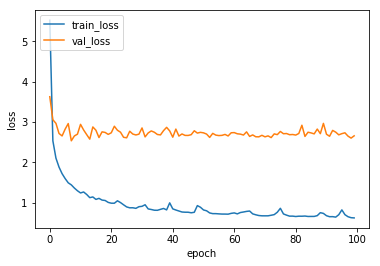

In [39]:
# 5. 학습과정 살펴보기
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
#plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

In [40]:
# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, verbose=0)
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: ', testScore)

Train Score:  [0.6087478220204048, 0.7621143599621205]
Validataion Score:  [2.659749334716319, 0.7169313791769436]
Test Score:  [2.897584039510639, 0.2590245697293247]


In [51]:
#%%timeit

# 7. 모델 사용하기
look_ahead = 30
xhat = x_test[500, None]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(xhat, batch_size=32)
    predictions[i] = prediction
    xhat = np.hstack([xhat[:,1:],prediction])

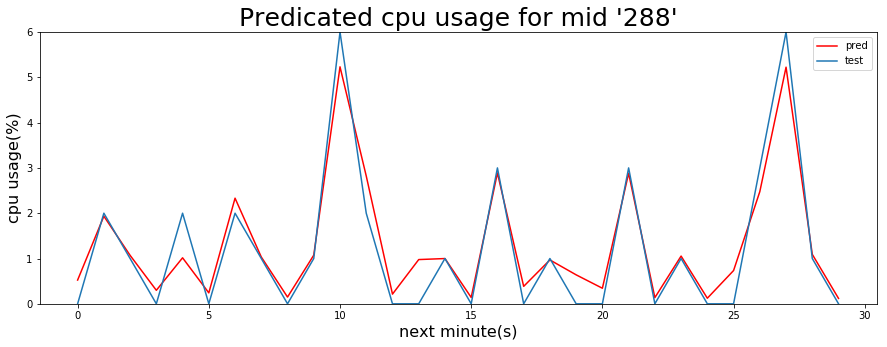

In [52]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(look_ahead), predictions,'r',label="pred")
plt.plot(np.arange(look_ahead), y_test[500:500+look_ahead], label="test")
plt.ylim(0,6)
plt.legend(loc='best')
plt.title("Predicated cpu usage for mid '288'", fontsize=25)
plt.xlabel('next minute(s)', fontsize=16)
plt.ylabel('cpu usage(%)', fontsize=16)
# fig = plt.gcf()
# plt.draw()
# fig.savefig('mlp2.png')
plt.show()

In [53]:
model.save("mlp-adam.h5")

In [54]:
from keras.models import load_model
model = load_model("mlp-adam.h5")

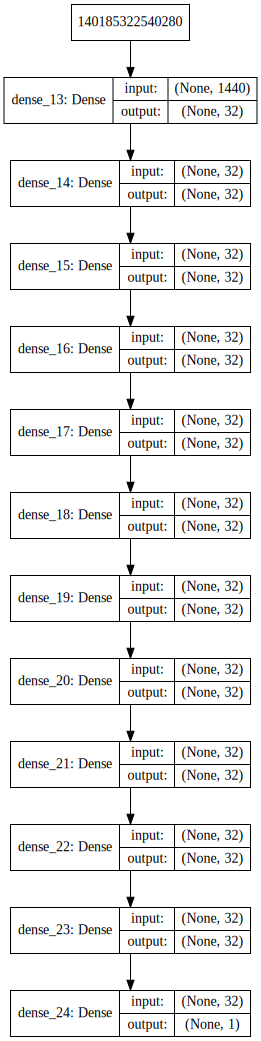

In [55]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))